In [ ]:
!pip install kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download angelinehw/mnist-60
#! unzip omniglot


  0% 0.00/428k [00:00<?, ?B/s]
100% 428k/428k [00:00<00:00, 94.1MB/s]


In [ ]:
!unzip mnist-60

Archive:  mnist-60.zip
  inflating: mnist_test/0/img_1.jpg  
  inflating: mnist_test/0/img_108.jpg  
  inflating: mnist_test/0/img_110.jpg  
  inflating: mnist_test/0/img_111.jpg  
  inflating: mnist_test/0/img_114.jpg  
  inflating: mnist_test/0/img_129.jpg  
  inflating: mnist_test/0/img_141.jpg  
  inflating: mnist_test/0/img_146.jpg  
  inflating: mnist_test/0/img_149.jpg  
  inflating: mnist_test/0/img_153.jpg  
  inflating: mnist_test/0/img_157.jpg  
  inflating: mnist_test/0/img_17.jpg  
  inflating: mnist_test/0/img_183.jpg  
  inflating: mnist_test/0/img_188.jpg  
  inflating: mnist_test/0/img_193.jpg  
  inflating: mnist_test/0/img_195.jpg  
  inflating: mnist_test/0/img_196.jpg  
  inflating: mnist_test/0/img_200.jpg  
  inflating: mnist_test/0/img_201.jpg  
  inflating: mnist_test/0/img_203.jpg  
  inflating: mnist_test/0/img_204.jpg  
  inflating: mnist_test/0/img_23.jpg  
  inflating: mnist_test/0/img_248.jpg  
  inflating: mnist_test/0/img_251.jpg  
  inflating: mnist_te

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm #for progress bar
import cv2 #for image processing
from numpy import random as rng
from sklearn.utils import shuffle
import pickle
import time

from tensorflow.keras.layers import Input, Lambda, Conv2D, MaxPooling2D, BatchNormalization, Dense, Flatten, Activation, Dropout
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import backend as K
from PIL import Image

In [ ]:
from keras.models import load_model
bce_size_35 = load_model('/content/gdrive/MyDrive/project/phase_2/omniglot-siamese-bce_size_35_256_7k.h5')

In [ ]:
path = '/content/mnist_test'

In [ ]:
def create_dataset(img_folder):
  X=[]
  for dirl in os.listdir(img_folder):
    t_folder = os.listdir(os.path.join(img_folder,dirl))
    #print(t_folder)
    cat =[]

    for file in os.listdir(os.path.join(img_folder,dirl)):
      image_path=os.path.join(img_folder,dirl,file)
      img = Image.open(image_path)
      re_size = img.resize((35,35))
      re_size.save(image_path)
      gray=cv2.imread(image_path,cv2.COLOR_BGR2RGB)
      #cat.append(cv2.cvtColor(cv2.imread(image_path),cv2.COLOR_BGR2GRAY))
      kernel = np.ones((2,2), np.uint8)
      img_erode = cv2.erode(gray, kernel, iterations=1)
      (T, threshInv) = cv2.threshold(img_erode, 0, 255,
	        cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
      #pyplot.figure()
      #pyplot.imshow(threshInv,cmap='gray')

      cat.append(threshInv)




    X.append(cat)
  X = np.array(X)


  return X

In [ ]:
T = create_dataset(path)

In [ ]:
T.shape

(10, 60, 35, 35)

In [ ]:
def make_one_shot_task(N,X):

    #Creating pairs of test image, support set for testing N way one-shot learning

    n_classes, n_examples, w, h = X.shape
    #from n_classes create an array labels/classes of size N=20 with repetition
    cats = rng.choice(n_classes,size=(N,),replace=False)

    #each character/class has 20 examples. From that create an array of size N=20 with repetition
    indices = rng.choice(n_examples,size=(N,))

    #from the character label array pick the first label
    true_cat = cats[0]

    #from 20 samples, randomly chose one sample
    ex1 = rng.randint(n_examples)

    # from test/val image from true_cat label pick the ex1 th sample and reshape it
    test_image = np.array([X[true_cat,ex1]]*N).reshape(N,w,h,1)

    # cats has the class/character
    # indices is the sample image of size 20
    support_set = X[cats,indices].reshape(N,w,h,1)
    targets = np.zeros((N,))
    targets[0] = 1

    test_image,support_set,targets = shuffle(test_image,support_set,targets)
   # print("Classes", cats)
    #print("Indices", indices)
    #print("QueryImage", true_cat)
    #print("ex1",ex1)
    #print("targets",targets)

    return [test_image,support_set], targets

In [ ]:
def test_one_shot(model,N,k,X):
    n_correct = 0
    for _ in range(k):
        inputs, outputs = make_one_shot_task(N,X)
        #plot_oneshot_task(inputs)
        preds = model.predict(inputs)
        if np.argmax(outputs) == np.argmax(preds):
            n_correct += 1
       # print(outputs)
        #print("O",np.argmax(outputs))
        #print("P",np.argmax(preds))
    return n_correct / k

In [ ]:
#testing for 10-way one shot learning

for i in range(20):
  print('Final Validation Accuracy using 250 20-Way One Shot Learning:', round(test_one_shot(bce_size_35,10,250,T) * 100,2))

Final Validation Accuracy using 250 20-Way One Shot Learning: 66.4
Final Validation Accuracy using 250 20-Way One Shot Learning: 58.0
Final Validation Accuracy using 250 20-Way One Shot Learning: 53.6
Final Validation Accuracy using 250 20-Way One Shot Learning: 54.8
Final Validation Accuracy using 250 20-Way One Shot Learning: 57.6
Final Validation Accuracy using 250 20-Way One Shot Learning: 55.6
Final Validation Accuracy using 250 20-Way One Shot Learning: 55.6
Final Validation Accuracy using 250 20-Way One Shot Learning: 52.8
Final Validation Accuracy using 250 20-Way One Shot Learning: 62.8
Final Validation Accuracy using 250 20-Way One Shot Learning: 60.8
Final Validation Accuracy using 250 20-Way One Shot Learning: 56.0
Final Validation Accuracy using 250 20-Way One Shot Learning: 57.2
Final Validation Accuracy using 250 20-Way One Shot Learning: 55.2
Final Validation Accuracy using 250 20-Way One Shot Learning: 56.8
Final Validation Accuracy using 250 20-Way One Shot Learning: 

In [ ]:
#testing for 5-way one shot learning

for i in range(20):
  print('Final Validation Accuracy using 250 20-Way One Shot Learning:', round(test_one_shot(bce_size_35,5,250,T) * 100,2))

Final Validation Accuracy using 250 20-Way One Shot Learning: 72.8
Final Validation Accuracy using 250 20-Way One Shot Learning: 69.6
Final Validation Accuracy using 250 20-Way One Shot Learning: 70.4
Final Validation Accuracy using 250 20-Way One Shot Learning: 69.2
Final Validation Accuracy using 250 20-Way One Shot Learning: 68.4
Final Validation Accuracy using 250 20-Way One Shot Learning: 70.0
Final Validation Accuracy using 250 20-Way One Shot Learning: 63.2
Final Validation Accuracy using 250 20-Way One Shot Learning: 71.2
Final Validation Accuracy using 250 20-Way One Shot Learning: 65.6
Final Validation Accuracy using 250 20-Way One Shot Learning: 70.4
Final Validation Accuracy using 250 20-Way One Shot Learning: 68.8
Final Validation Accuracy using 250 20-Way One Shot Learning: 72.4
Final Validation Accuracy using 250 20-Way One Shot Learning: 71.2
Final Validation Accuracy using 250 20-Way One Shot Learning: 68.0
Final Validation Accuracy using 250 20-Way One Shot Learning: 

In [ ]:
#testing for 3-way one shot learning

for i in range(20):
  print('Final Validation Accuracy using 250 20-Way One Shot Learning:', round(test_one_shot(bce_size_35,3,250,T) * 100,2))

Final Validation Accuracy using 250 20-Way One Shot Learning: 59.6
Final Validation Accuracy using 250 20-Way One Shot Learning: 61.2
Final Validation Accuracy using 250 20-Way One Shot Learning: 60.4
Final Validation Accuracy using 250 20-Way One Shot Learning: 60.4
Final Validation Accuracy using 250 20-Way One Shot Learning: 55.6
Final Validation Accuracy using 250 20-Way One Shot Learning: 60.8
Final Validation Accuracy using 250 20-Way One Shot Learning: 57.2
Final Validation Accuracy using 250 20-Way One Shot Learning: 54.4
Final Validation Accuracy using 250 20-Way One Shot Learning: 63.2
Final Validation Accuracy using 250 20-Way One Shot Learning: 59.2
Final Validation Accuracy using 250 20-Way One Shot Learning: 57.2
Final Validation Accuracy using 250 20-Way One Shot Learning: 61.6
Final Validation Accuracy using 250 20-Way One Shot Learning: 65.6
Final Validation Accuracy using 250 20-Way One Shot Learning: 60.0
Final Validation Accuracy using 250 20-Way One Shot Learning: 

In [ ]:
def create_dataset(img_folder):
  X=[]
  for dirl in os.listdir(img_folder):
    t_folder = os.listdir(os.path.join(img_folder,dirl))
    #print(t_folder)
    cat =[]

    for file in os.listdir(os.path.join(img_folder,dirl)):
      image_path=os.path.join(img_folder,dirl,file)
      img = Image.open(image_path)
      img = img.resize((35,35))
      img.save(image_path)
        #image=cv2.imread(image_path,cv2.COLOR_BGR2RGB)
      cat.append(cv2.cvtColor(cv2.imread(image_path),cv2.COLOR_BGR2GRAY))


            #if any([file.endswith(x) for x in ['.jpeg', '.jpg']]):


    X.append(cat)
  X = np.array(X)


  return X

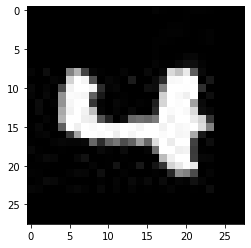

In [ ]:

from matplotlib import pyplot
image_path = '/content/digit2.jpg'
#img = Image.open(image_path)
i = pyplot.imread(image_path)
pyplot.imshow(i,cmap='gray')


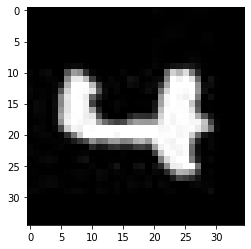

In [ ]:
img = cv2.imread(image_path)
img = Image.open(image_path)
re = img.resize((35,35))
re.save(image_path)
pyplot.figure()
pyplot.imshow(re,cmap='gray')

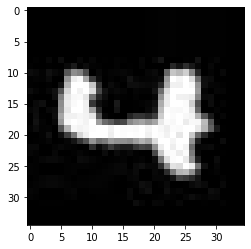

In [ ]:
gray = cv2.cvtColor(cv2.imread(image_path),cv2.COLOR_BGR2GRAY)
pyplot.figure()
pyplot.imshow(gray,cmap='gray')

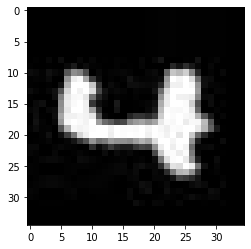

In [ ]:

blurred = cv2.GaussianBlur(gray, (9, 9), 0)
pyplot.figure()
pyplot.imshow(gray,cmap='gray')


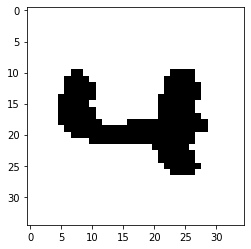

In [ ]:
(T, threshInv) = cv2.threshold(gray, 0, 255,
	cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
pyplot.figure()
pyplot.imshow(threshInv,cmap='gray')

im = Image.fromarray(threshInv)
im.save(image_path)

#threshInv.save(image_path)


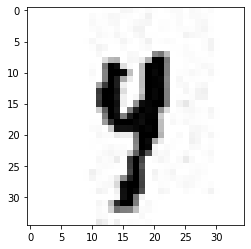

In [ ]:
img = cv2.imread(image_path)
img = Image.open(image_path)
#re = img.resize((35,35))
#re.save(image_path)

#img = cv2.imread(path)

#plt.imshow(img)
#plt.show()
#i = pyplot.imread(image_path)
#pyplot.imshow(i,cmap='gray')


pyplot.figure()
pyplot.imshow(re,cmap='gray')

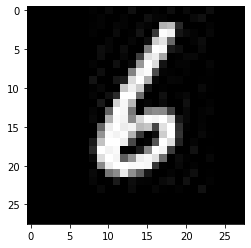

In [ ]:

from matplotlib import pyplot
image_path = '/content/digit2.jpg'
#img = Image.open(image_path)
i = pyplot.imread(image_path)
pyplot.imshow(i,cmap='gray')

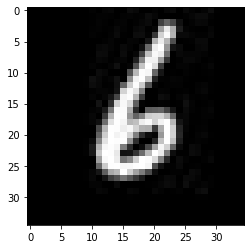

In [ ]:
img = cv2.imread(image_path)
img = Image.open(image_path)
re = img.resize((35,35))
re.save(image_path)
pyplot.figure()
pyplot.imshow(re,cmap='gray')

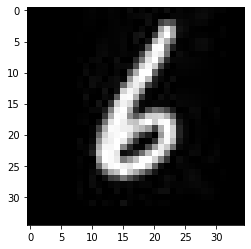

In [ ]:
gray = cv2.cvtColor(cv2.imread(image_path),cv2.COLOR_BGR2GRAY)
pyplot.figure()
pyplot.imshow(gray,cmap='gray')

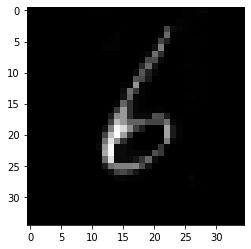

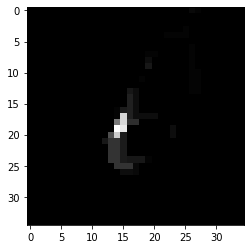

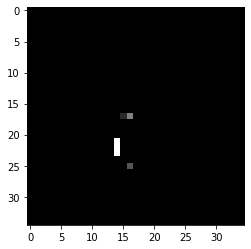

In [ ]:
for i in range(0, 3):
  eroded = cv2.erode(gray.copy(), None, iterations=i + 1)
  pyplot.figure()
  pyplot.imshow(eroded,cmap='gray')


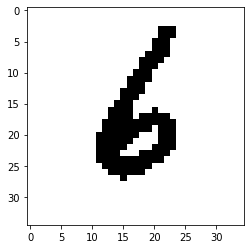

In [ ]:
(T, threshInv) = cv2.threshold(gray, 0, 255,
	cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
pyplot.figure()
pyplot.imshow(threshInv,cmap='gray')

#im = Image.fromarray(threshInv)
#im.save(image_path)

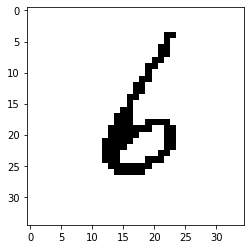

In [ ]:
kernel = np.ones((2,2), np.uint8)
img_dilation = cv2.dilate(threshInv, kernel, iterations=1)
pyplot.figure()
pyplot.imshow(img_dilation,cmap='gray')

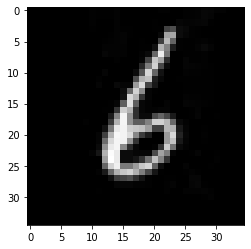

In [ ]:
kernel = np.ones((2,2), np.uint8)
img_erosion = cv2.erode(gray.copy(), kernel, iterations=1)
pyplot.figure()
pyplot.imshow(img_erosion,cmap='gray')


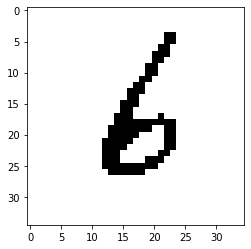

In [ ]:
(T, threshInv) = cv2.threshold(img_erosion, 0, 255,
	cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
pyplot.figure()
pyplot.imshow(threshInv,cmap='gray')

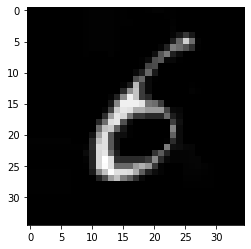

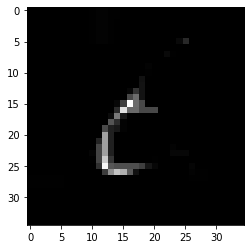

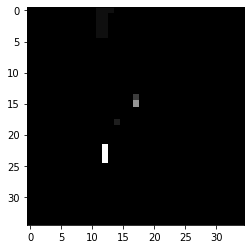

In [ ]:
for i in range(0, 3):
  eroded = cv2.erode(gray.copy(), None, iterations=i + 1)
  pyplot.figure()
  pyplot.imshow(eroded,cmap='gray')



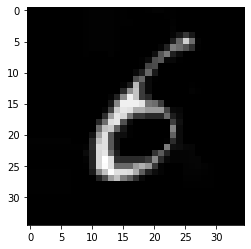

In [ ]:
eroded = cv2.erode(gray.copy(), None, iterations=1)
pyplot.figure()
pyplot.imshow(eroded,cmap='gray')

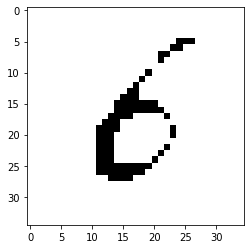

In [ ]:
(T, threshInv) = cv2.threshold(eroded, 0, 255,
	cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
pyplot.figure()
pyplot.imshow(threshInv,cmap='gray')

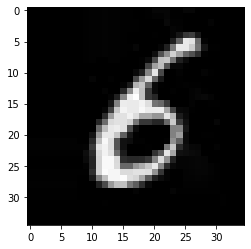

In [ ]:
kernel = np.ones((2,2), np.uint8)
img_dilation = cv2.erode(gray, kernel, iterations=1)
pyplot.figure()
pyplot.imshow(img_dilation,cmap='gray')

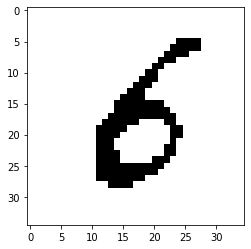

In [ ]:
(T, threshInv) = cv2.threshold(img_dilation, 0, 255,
	cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
pyplot.figure()
pyplot.imshow(threshInv,cmap='gray')

In [ ]:
#testing for 10-way one shot learning

for i in range(20):
  print('Final Validation Accuracy using 250 20-Way One Shot Learning:', round(test_one_shot(bce_size_35,10,250,T) * 100,2))

Final Validation Accuracy using 250 20-Way One Shot Learning: 53.6
Final Validation Accuracy using 250 20-Way One Shot Learning: 59.6
Final Validation Accuracy using 250 20-Way One Shot Learning: 54.4
Final Validation Accuracy using 250 20-Way One Shot Learning: 56.8
Final Validation Accuracy using 250 20-Way One Shot Learning: 52.4
Final Validation Accuracy using 250 20-Way One Shot Learning: 54.0
Final Validation Accuracy using 250 20-Way One Shot Learning: 58.4
Final Validation Accuracy using 250 20-Way One Shot Learning: 60.0
Final Validation Accuracy using 250 20-Way One Shot Learning: 58.0
Final Validation Accuracy using 250 20-Way One Shot Learning: 58.4
Final Validation Accuracy using 250 20-Way One Shot Learning: 49.2
Final Validation Accuracy using 250 20-Way One Shot Learning: 55.2
Final Validation Accuracy using 250 20-Way One Shot Learning: 55.6
Final Validation Accuracy using 250 20-Way One Shot Learning: 53.2
Final Validation Accuracy using 250 20-Way One Shot Learning: 

In [ ]:
#testing for 5-way one shot learning

for i in range(20):
  print('Final Validation Accuracy using 250 20-Way One Shot Learning:', round(test_one_shot(bce_size_35,5,250,T) * 100,2))

Final Validation Accuracy using 250 20-Way One Shot Learning: 66.4
Final Validation Accuracy using 250 20-Way One Shot Learning: 71.2
Final Validation Accuracy using 250 20-Way One Shot Learning: 72.8
Final Validation Accuracy using 250 20-Way One Shot Learning: 60.4
Final Validation Accuracy using 250 20-Way One Shot Learning: 66.4
Final Validation Accuracy using 250 20-Way One Shot Learning: 71.2
Final Validation Accuracy using 250 20-Way One Shot Learning: 66.8
Final Validation Accuracy using 250 20-Way One Shot Learning: 69.2
Final Validation Accuracy using 250 20-Way One Shot Learning: 66.8
Final Validation Accuracy using 250 20-Way One Shot Learning: 64.4
Final Validation Accuracy using 250 20-Way One Shot Learning: 68.0
Final Validation Accuracy using 250 20-Way One Shot Learning: 72.0
Final Validation Accuracy using 250 20-Way One Shot Learning: 63.2
Final Validation Accuracy using 250 20-Way One Shot Learning: 65.2
Final Validation Accuracy using 250 20-Way One Shot Learning: 

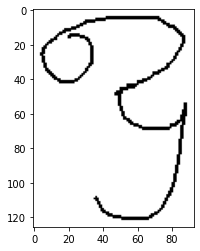

In [ ]:

from matplotlib import pyplot
image_path = '/content/char1.jpg'
#img = Image.open(image_path)
i = pyplot.imread(image_path)
pyplot.imshow(i,cmap='gray')


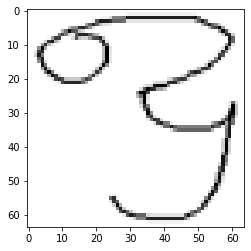

In [ ]:
img = cv2.imread(image_path)
img = Image.open(image_path)
re = img.resize((64,64))
re.save(image_path)
pyplot.figure()
pyplot.imshow(re,cmap='gray')

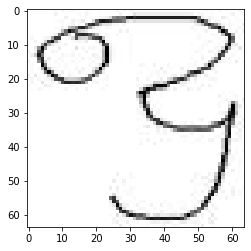

In [ ]:
gray = cv2.cvtColor(cv2.imread(image_path),cv2.COLOR_BGR2GRAY)
pyplot.figure()
pyplot.imshow(gray,cmap='gray')

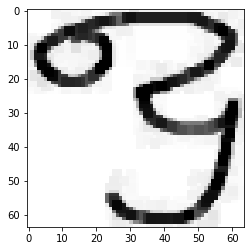

In [ ]:
kernel = np.ones((3,3), np.uint8)
img_dilation = cv2.erode(gray, kernel, iterations=1)
pyplot.figure()
pyplot.imshow(img_dilation,cmap='gray')

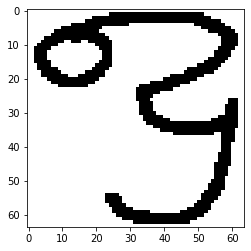

In [ ]:
(T, threshInv) = cv2.threshold(img_dilation, 0, 255,
	cv2.THRESH_BINARY | cv2.THRESH_OTSU)
pyplot.figure()
pyplot.imshow(threshInv,cmap='gray')